In [34]:
import numpy as np
import polars as pl
import seaborn as sns
import os
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [35]:
REPEAT = 50
CV = 4
features = ["color"]

features = sorted(features)
features = "_".join(features)
root_features  = "/home/surayuth/her2/results/baseline_feat|level_32"

ROOT = os.path.join(root_features, features)
exp_f1 = np.zeros(REPEAT)
exp_recall = np.zeros(REPEAT)
exp_precision = np.zeros(REPEAT)

for r in range(REPEAT):
    f1s = np.zeros(CV)
    recalls = np.zeros(CV)
    precisions = np.zeros(CV)
    for cv in range(4): 
        path = f"{ROOT}/{r}_{cv}_{features}.csv"
        df = pl.read_csv(path)

        agg = df \
            .group_by("case") \
            .agg(
                pl.col("label").first(),
                pl.col("ihc_score").first(),
                pl.col("prob").mean().alias("avg")
            ) \
            .with_columns(
                pl.when(pl.col("avg") > 0.5).then(1).otherwise(0)
                .alias("pred")
            ) \
            .sort("label", "ihc_score") 

        labels = agg.select("label")
        preds = agg.select("pred")

        f1 = f1_score(labels, preds)
        recall = recall_score(labels, preds)
        precision = precision_score(labels, preds)

        f1s[cv] = f1
        recalls[cv] = recall
        precisions[cv] = precision

    exp_f1[r] = f1s.mean()
    exp_recall[r] = recalls.mean()
    exp_precision[r] = precisions.mean()

print(f"f1: {exp_f1.mean():.3f}")
print(f"recall: {exp_recall.mean():.3f}")
print(f"precision: {exp_precision.mean():.3f}")

f1: 0.653
recall: 0.805
precision: 0.565


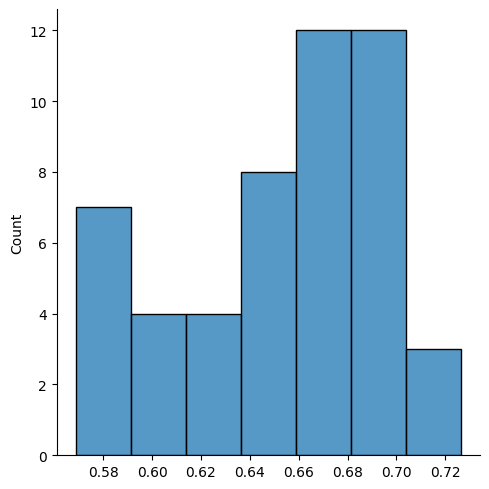

In [36]:
sns.displot(data=exp_f1)